# Setup

In [0]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

In [0]:
import mlflow
import mlflow.pytorch

# Param Setup

In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

# Dataset

In [5]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms)
test_set = datasets.MNIST('../data', train=False, download=True, transform=transforms)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


113.5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


180.4%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


# Model

In [0]:
class Model(nn.Module):
    def __init__(self, nH=32):
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
def train(epoch):
    
    model.train()

    for batch_id, data in enumerate(trainloader):
        inputs, labels = data

        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if batch_id%args.log_interval == 0:
            pos = epoch * len(trainloader) + batch_id
            mlflow.log_metric('train loss', loss.data.item()/len(inputs)*1000)

            print('Train Epoch: {} [{}/{} ({:,.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(trainloader.dataset),
                100. * batch_id / len(trainloader), loss.data.item()
            ))

In [0]:
def test(epoch):

    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10,10])

    with torch.no_grad():

        for inputs, labels in testloader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()

            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1

        test_loss /= len(testloader.dataset)
        test_accuracy = 100.0 * correct/len(testloader.dataset)

        pos = (epoch+1)*len(trainloader)
        mlflow.log_metric('test loss', test_loss*1000)
        mlflow.log_metric('test accuracy', test_accuracy)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader.dataset), test_accuracy
        ))

        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                   yticks=np.arange(confusion_matrix.shape[0]),
                   xticklabels=classes, yticklabels=classes,
                   ylabel='True label',
                   xlabel='Predicted label',
                   title='Epoch %d' %epoch)
            thresh = confusion_matrix.max()/2.0
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j,i,int(confusion_matrix[i,j]),
                            ha='center', va='center',
                            color='white' if confusion_matrix[i][j]>thresh else 'black')
            
            fig.tight_layout()

            image_path = 'images/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)

# Hyperparam Tuning Loop


LR= 0.01, Momentum= 0.90, Hidden Nodes= 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.978
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.480
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.412
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.245
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.429
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.350
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.220
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.343
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.322
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.311
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.380

Test set: Average loss: 0.0010, Accuracy: 9246/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.217
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.215
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.252
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.353
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.204
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.292
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.203
Train Epoch: 2 

/home/sreyan/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



LR= 0.01, Momentum= 0.95, Hidden Nodes= 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.893
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.480
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.451
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.444
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.335
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.427
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.338
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.305
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.241
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.187
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.269

Test set: Average loss: 0.0009, Accuracy: 9359/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.189
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.310
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.260
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.178
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.216
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.204
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.186
Train Epoch: 2 

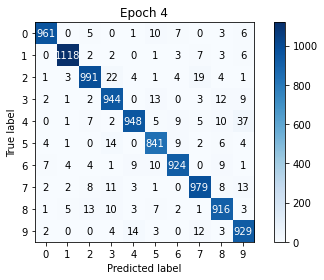

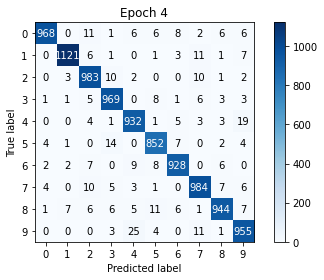

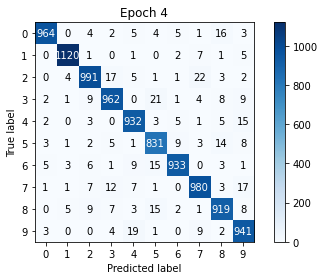

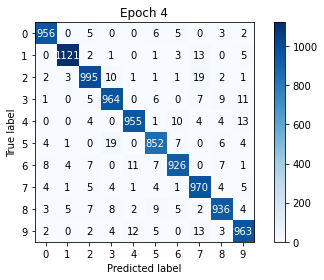

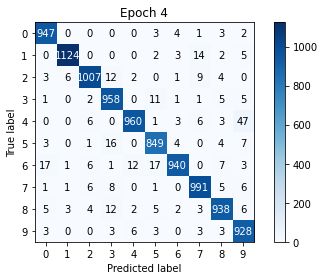

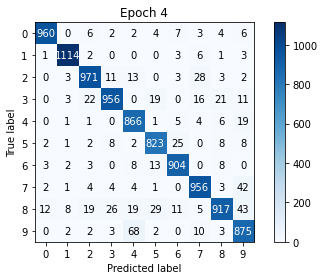

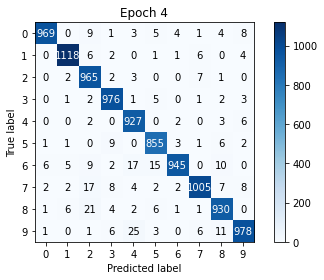

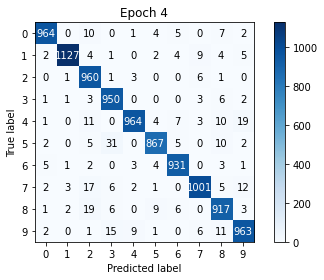

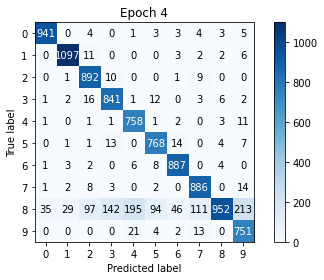

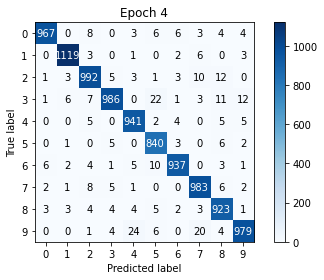

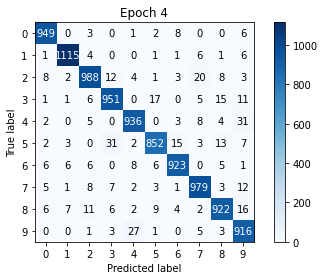

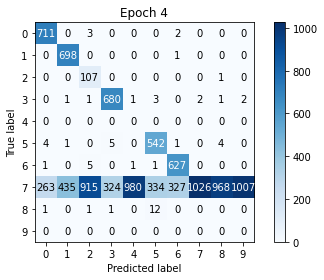

In [24]:
mlflow.create_experiment('Fixed nH')
mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:

            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR= %.2f, Momentum= %.2f, Hidden Nodes= %d\n' %(lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

            with mlflow.start_run() as run:
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden nodes', hidden_nodes)

                for epoch in range(1, args.epochs+1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")
